In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pd.set_option("display.max_columns", None)

In [7]:
balls_df = pd.read_csv("data/processed/ball_by_ball.csv")
matches_df = pd.read_csv("data/processed/india_t20i_matches_enriched.csv")

balls_df.head()


,match_id,batting_team,over,batter,bowler,runs_batter,total_runs,wicket
0,1043989,Australia,0,MM Lanning,LMM Tahuhu,1,1,0
1,1043989,Australia,0,BL Mooney,LMM Tahuhu,0,0,0
2,1043989,Australia,0,BL Mooney,LMM Tahuhu,0,0,0
3,1043989,Australia,0,BL Mooney,LMM Tahuhu,1,1,0
4,1043989,Australia,0,MM Lanning,LMM Tahuhu,0,0,0


In [9]:
balls_df = balls_df.merge(
    matches_df[["match_id", "india_result"]],
    on="match_id",
    how="left"
)


We merge ball-by-ball data with match results to analyze player contributions specifically in winning matches.


In [12]:
india_batting = balls_df[
    balls_df["batting_team"] == "India"
].copy()


In [14]:
batting_wins = india_batting[
    india_batting["india_result"] == "Win"
]

batting_losses = india_batting[
    india_batting["india_result"] == "Loss"
]


In [16]:
batting_win_stats = batting_wins.groupby("batter").agg(
    runs_in_wins=("runs_batter", "sum"),
    balls_in_wins=("runs_batter", "count")
)

batting_win_stats["sr_in_wins"] = (
    batting_win_stats["runs_in_wins"] /
    batting_win_stats["balls_in_wins"]
) * 100


In [18]:
batting_loss_stats = batting_losses.groupby("batter").agg(
    runs_in_losses=("runs_batter", "sum"),
    balls_in_losses=("runs_batter", "count")
)

batting_loss_stats["sr_in_losses"] = (
    batting_loss_stats["runs_in_losses"] /
    batting_loss_stats["balls_in_losses"]
) * 100


In [20]:
batting_impact = batting_win_stats.merge(
    batting_loss_stats,
    on="batter",
    how="left"
)

batting_impact["impact_score"] = (
    batting_impact["runs_in_wins"] * 0.6 +
    batting_impact["sr_in_wins"] * 0.4
)

batting_impact.sort_values("impact_score", ascending=False).head(10)


,runs_in_wins,balls_in_wins,sr_in_wins,runs_in_losses,balls_in_losses,sr_in_losses,impact_score
batter,,,,,,,
S Mandhana,2276,1878,121.192758,1392.0,1163.0,119.690456,1414.077103
Shafali Verma,1753,1331,131.705485,590.0,497.0,118.712274,1104.482194
H Kaur,1646,1434,114.783821,1228.0,1178.0,104.244482,1033.513529
JI Rodrigues,1615,1364,118.401760,724.0,706.0,102.549575,1016.360704
M Raj,812,800,101.500000,468.0,569.0,82.249561,527.800000
RM Ghosh,497,343,144.897959,552.0,430.0,128.372093,356.159184
DB Sharma,473,466,101.502146,608.0,603.0,100.829187,324.400858
V Krishnamurthy,298,260,114.615385,191.0,208.0,91.826923,224.646154
D Hemalatha,226,182,124.175824,50.0,74.0,67.567568,185.270330


In [22]:
india_bowling = balls_df[
    balls_df["batting_team"] != "India"
].copy()


In [24]:
bowling_wins = india_bowling[
    india_bowling["india_result"] == "Win"
]

bowling_losses = india_bowling[
    india_bowling["india_result"] == "Loss"
]


In [26]:
bowling_win_stats = bowling_wins.groupby("bowler").agg(
    runs_conceded_in_wins=("total_runs", "sum"),
    balls_in_wins=("total_runs", "count"),
    wickets_in_wins=("wicket", "sum")
)

bowling_win_stats["economy_in_wins"] = (
    bowling_win_stats["runs_conceded_in_wins"] /
    (bowling_win_stats["balls_in_wins"] / 6)
)


In [28]:
bowling_win_stats["impact_score"] = (
    bowling_win_stats["wickets_in_wins"] * 0.7 -
    bowling_win_stats["economy_in_wins"] * 0.3
)

bowling_win_stats.sort_values("impact_score", ascending=False).head(10)


,runs_conceded_in_wins,balls_in_wins,wickets_in_wins,economy_in_wins,impact_score
bowler,,,,,
DB Sharma,1414,1648,106,5.148058,72.655583
RP Yadav,1017,1096,89,5.567518,60.629745
Poonam Yadav,621,724,55,5.146409,36.956077
P Vastrakar,752,804,44,5.611940,29.116418
Renuka Singh,639,679,41,5.646539,27.006038
RS Gayakwad,459,531,34,5.186441,22.244068
AA Patil,333,417,33,4.791367,21.662590
S Pandey,491,484,28,6.086777,17.773967
A Reddy,537,459,24,7.019608,14.694118


Top Batters

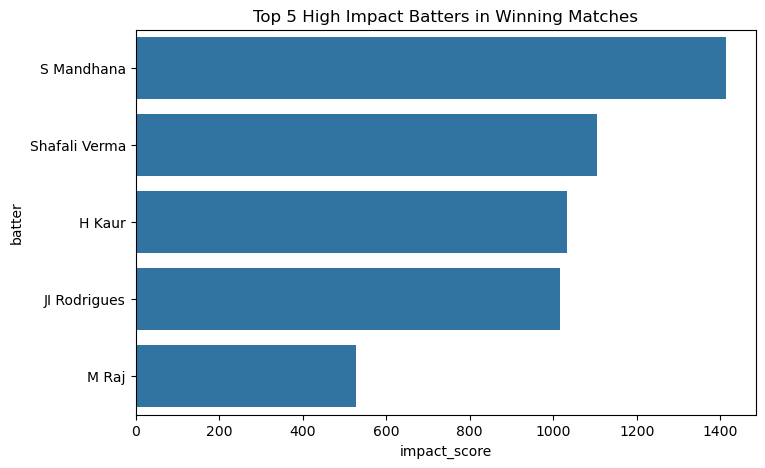

In [30]:
top_batters = batting_impact.sort_values(
    "impact_score", ascending=False
).head(5)

plt.figure(figsize=(8,5))
sns.barplot(
    data=top_batters,
    x="impact_score",
    y=top_batters.index
)
plt.title("Top 5 High Impact Batters in Winning Matches")
plt.show()


Top Batters

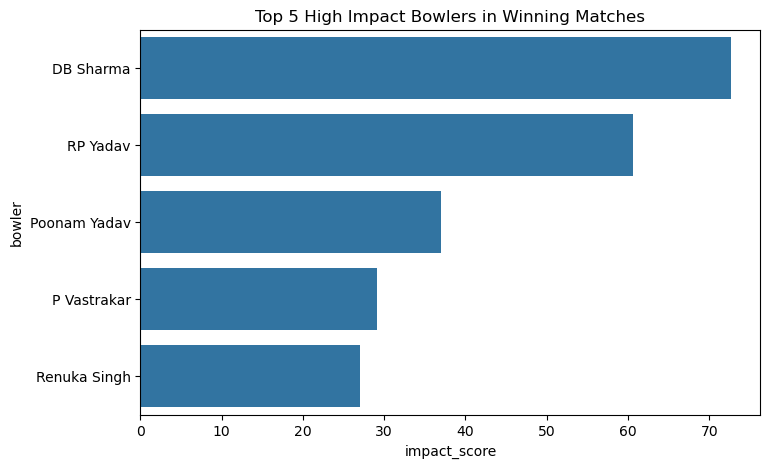

In [32]:
top_bowlers = bowling_win_stats.sort_values(
    "impact_score", ascending=False
).head(5)

plt.figure(figsize=(8,5))
sns.barplot(
    data=top_bowlers,
    x="impact_score",
    y=top_bowlers.index
)
plt.title("Top 5 High Impact Bowlers in Winning Matches")
plt.show()
